In [1]:
# Python standard library
import io
import os

# Scientific computing
#c.IPKernelApp.pyplot = u'inline'

import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn

# Imports the Google Cloud client library
from google.cloud import vision
from google.cloud.vision import types

ModuleNotFoundError: No module named 'google.cloud'

TypeError: Image data can not convert to float

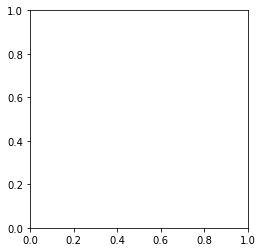

In [2]:
# The name of the image file to annotate
file_directory = '/home/prestonh/bookshelf/img/'
file_name = 'insight_shelf_0.jpg'
file_path = file_directory + file_name

# Load and look at the image
img = cv2.imread(file_path, 0)


plt.imshow(img, cmap = 'gray')
plt.show()

# Instantiates a client
client = vision.ImageAnnotatorClient()

# Loads the image into memory
with io.open(file_path, 'rb') as image_file:
    content = image_file.read()
img_bin = types.Image(content=content)

In [3]:
response = client.document_text_detection(image=img_bin)

texts = response.text_annotations
print('response type:', type(response))
print('texts type:', type(texts))

NameError: name 'client' is not defined

In [4]:
class Word(object):
    '''
    Simple Word class consisting of the word"s value ('string') and the bounding box ('bounding_box')
    containing the word
    '''
    
    def __init__(self, string, bounding_box):
        self.string = string
        self.bounding_box = bounding_box
        
    def FromGoogleText(google_text):
        '''
        Converts a google text_annotation into a simpler Word format
        args:
            google_text: the google text_annotation object
        '''
        
        string = google_text.description
        bounding_box = BoundingBox.FromGoogleBoundingPoly(google_text.bounding_poly)
        
        return Word(string, bounding_box)
        

class BoundingBox(object):
    def __init__(self, xs, ys):
        self.xs = xs
        self.ys = ys
        
    def Center(self):
        '''
        Returns the center of the bounding box object
        '''
        xc = (self.xs[0] + self.xs[1] + self.xs[2] + self.xs[3])/4.
        yc = (self.ys[0] + self.ys[1] + self.ys[2] + self.ys[3])/4.
        
        return xc, yc
    

    def ImageToBoundingBoxCoordinateTransformation(self, x, y):
        '''
        The coordinate frame of the bounding box is defined by its center (the origin), the long-axis
        (x-axis, or along the spine usually), and the short-axis (y-axis, lateral to spine direction usually)
        This takes coordinates
        '''
        long_axis_angle = self.LongAxisAngle()
        xc, yc = self.Center()
        
        xp = np.cos(long_axis_angle)*(x-xc) + np.sin(long_axis_angle)*(y-yc)
        yp = -np.sin(long_axis_angle)*(x-xc) + np.cos(long_axis_angle)*(y-yc)
        
        return (xp, yp)
    
    def FitLine(self):
        '''
        Gets the line in the form y=mx+b (returns slope and y-intercept) of the bounding box object.
        Does this by finding the long axis angle and center
        Returned as a tuple
        '''
        
        center = self.Center()
        x = center[0]
        y = center[1]
        
        m = np.tan(self.LongAxisAngle())
        b = y-m*x
        
        return (m, b)
    
    def LongAxisAngle(self):
        '''
        Returns the long axis angle of the bounding box object
        '''
        
        l1 = (self.ys[1]-self.ys[0])**2. + (self.xs[1]-self.xs[0])**2.
        l2 = (self.ys[2]-self.ys[1])**2. + (self.xs[2]-self.xs[1])**2.
        
        
        if l1 >= l2:
            return np.arctan2(self.ys[1]-self.ys[0], self.xs[1]-self.xs[0])
        else:
            return np.arctan2(self.ys[2]-self.ys[1], self.xs[2]-self.xs[1])
        
    
    def ShortAxisAngle(self):
        '''
        Returns the short axis of the bounding box object
        '''
        
        l1 = (self.ys[1]-self.ys[0])**2. + (self.xs[1]-self.xs[0])**2.
        l2 = (self.ys[2]-self.ys[1])**2. + (self.xs[2]-self.xs[1])**2.
        
        
        if l1 <= l2:
            return np.arctan2(self.ys[1]-self.ys[0], self.xs[1]-self.xs[0])
        else:
            return np.arctan2(self.ys[2]-self.ys[1], self.xs[2]-self.xs[1])

        
    
    def FromGoogleBoundingPoly(bounding_poly):
        '''
        Factory function for creating a vertex from a bounding poly
        args:
            bounding_poly: the bounding_poly object
        '''
        
        xs = []
        ys = []
        for vertex in bounding_poly.vertices:
            xs.append(vertex.x)
            ys.append(vertex.y)
        
        return BoundingBox(xs, ys)
        
        

def GoogleBoundingPolyToVertices(bounding_poly):
    '''
    Converts the vertices in a bounding_poly object to a list of tuples (more convenient
    to work with)
    args:
        bounding_poly: The bounding_poly object
    '''
    
    for vertex in bounding_poly.vertices:
        x = vertex.x
        y = vertex.y
        vertices.append((x,y))
        
    return vertices
    
def PlotAnnotatedImage(img, words):
    if type(words) == 'text_annotations':
        PlotAnnotatedImage_GoogleCloudVision()
    elif type(words) == '__main__.Words':
        PlotAnnotatedImage_Words()
    
def PlotAnnotatedImage_Words(img, words, color = 'red', show = True):
    '''
    Plots an image alongside all of the bounding boxes found by the GoogleCloudVision 
    document_text_detection() function
    args:
        img: the img, should be in normal numpy format
        texts: the text_annotations object returned by the GoogleCloudVision api
    '''
    
    for word in words:
        if color == 'random':
            color = np.random.rand(3)*1.
        bb = word.bounding_box
        plt.plot([bb.xs[0], bb.xs[1]], [bb.ys[0], bb.ys[1]], lw = 3, c = color)
        plt.plot([bb.xs[1], bb.xs[2]], [bb.ys[1], bb.ys[2]], lw = 3, c = color)
        plt.plot([bb.xs[2], bb.xs[3]], [bb.ys[2], bb.ys[3]], lw = 3, c = color)
        plt.plot([bb.xs[3], bb.xs[0]], [bb.ys[3], bb.ys[0]], lw = 3, c = color)
        
    plt.imshow(img, cmap = 'gray')
    
    if show:
        plt.show()
        
    
    
def PlotAnnotatedImage_GoogleCloudVision(img, texts):
    '''
    Plots an image alongside all of the bounding boxes found by the GoogleCloudVision 
    document_text_detection() function
    args:
        img: the img, should be in normal numpy format
        texts: the text_annotations object returned by the GoogleCloudVision api
    '''
    
    
    
    for text in texts:
        bb = BoundingBox.FromGoogleBoundingPoly(text.bounding_poly)
        plt.plot([bb.xs[0], bb.xs[1]], [bb.ys[0], bb.ys[1]], lw = 3, c = 'r')
        plt.plot([bb.xs[1], bb.xs[2]], [bb.ys[1], bb.ys[2]], lw = 3, c = 'r')
        plt.plot([bb.xs[2], bb.xs[3]], [bb.ys[2], bb.ys[3]], lw = 3, c = 'r')
        plt.plot([bb.xs[3], bb.xs[0]], [bb.ys[3], bb.ys[0]], lw = 3, c = 'r')
    
    plt.imshow(img, cmap = 'gray')
        
    plt.show()

In [5]:
words = [Word.FromGoogleText(text) for text in texts[1:]]

In [ ]:
ix = 51
word = words[ix]
other_words = [words[i] for i in range(len(words)) if i != ix]
PlotAnnotatedImage_Words(img, [words[ix]], color = 'random', show = False)

center = word.bounding_box.Center()
long_axis_angle = word.bounding_box.LongAxisAngle()
short_axis_angle = word.bounding_box.ShortAxisAngle()
plt.plot()

In [ ]:
print(word.bounding_box.Center())
print(word.bounding_box.LongAxisAngle()*180/np.pi)
print(word.bounding_box.ShortAxisAngle()*180/np.pi)

In [ ]:
long_axis_angle = word.bounding_box.LongAxisAngle()
print(long_axis_angle)

centers = np.array([words[i].bounding_box.Center() for i in range(len(words))])
centers = centers - centers[0]


theta = word.bounding_box.LongAxisAngle()
rot_matrix = np.array([[np.cos(theta), np.sin(theta)],[-np.sin(theta), np.cos(theta)]])

for i in range(len(centers)):
    centers[i,:] = np.dot(rot_matrix, centers[i,:].reshape(-1,1)).flatten()
    
angles = [word.bounding_box.LongAxisAngle() for word in words]
plt.scatter(angles[ix], centers[ix,1], marker = 'x', c = 'red')
plt.scatter(angles[1:], centers[1:,1])
plt.show()

In [ ]:
for word in words:
    plt.scatter(word.bounding_box.Center()[0], word.bounding_box.ShortAxisAngle()*180/np.pi)
plt.xlabel('x'), plt.ylabel('angle')
plt.grid()
plt.show()

for word in words:
    plt.scatter(word.bounding_box.Center()[0], word.bounding_box.LongAxisAngle()*180/np.pi)
plt.xlabel('y'), plt.ylabel('angle')
plt.grid()
plt.show()

In [ ]:
for word in words:
    
    plt.scatter(word.bounding_box.Center()[0], word.bounding_box.Center()[1])
    
    
plt.show()

In [ ]:
PlotAnnotatedImage_GoogleCloudVision(img, texts)


In [ ]:

for text in texts:
    print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y) for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

In [ ]:
def detect_text(path):
    """Detects text in the file."""
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()

    image = types.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
        print('\n"{}"'.format(text.description))

        vertices = (['({},{})'.format(vertex.x, vertex.y)
                    for vertex in text.bounding_poly.vertices])

        print('bounds: {}'.format(','.join(vertices)))